In [1]:
#Local Outlier Factor Anomaly Detection

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('filtered_data.csv')
#df = df[['speed', 'flow', 'occ']]
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       200000 non-null  object 
 1   interval  200000 non-null  int64  
 2   detid     200000 non-null  object 
 3   flow      200000 non-null  float64
 4   occ       200000 non-null  float64
 5   error     158545 non-null  float64
 6   city      200000 non-null  object 
 7   speed     200000 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 12.2+ MB


In [12]:
# Optimize DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset
det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}
scaler = StandardScaler()

# Grid search parameters
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = range(2, 10)

# Store best parameters
global_best_params = {}
global_best_db_index = np.inf
global_best_ch_index = -1

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps

    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    X_scaled = scaler.fit_transform(sensor_data[features_to_scale])

    # Local best for current detector
    best_db_index = np.inf
    best_ch_index = -1
    best_params = {}

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_scaled)
            if len(set(labels)) - (1 if -1 in labels else 0) > 1:
                try:
                    db_index = davies_bouldin_score(X_scaled, labels)
                    ch_index = calinski_harabasz_score(X_scaled, labels)
                    if db_index < best_db_index:
                        best_db_index = db_index
                        best_params['db_index'] = db_index
                        best_params['eps_db'] = eps
                        best_params['min_samples_db'] = min_samples
                    if ch_index > best_ch_index:
                        best_ch_index = ch_index
                        best_params['ch_index'] = ch_index
                        best_params['eps_ch'] = eps
                        best_params['min_samples_ch'] = min_samples
                except ValueError as e:
                    continue

    # Update global best parameters
    if best_db_index < global_best_db_index:
        global_best_db_index = best_db_index
        global_best_params['eps_db'] = best_params['eps_db']
        global_best_params['min_samples_db'] = best_params['min_samples_db']

    if best_ch_index > global_best_ch_index:
        global_best_ch_index = best_ch_index
        global_best_params['eps_ch'] = best_params['eps_ch']
        global_best_params['min_samples_ch'] = best_params['min_samples_ch']

# After processing all detectors
print(f"Global Best DB Index Parameters: EPS: {global_best_params.get('eps_db')}, Min Samples: {global_best_params.get('min_samples_db')}")
print(f"Global Best CH Index Parameters: EPS: {global_best_params.get('eps_ch')}, Min Samples: {global_best_params.get('min_samples_ch')}")

Global Best DB Index Parameters: EPS: 0.9, Min Samples: 2
Global Best CH Index Parameters: EPS: 1.0, Min Samples: 2


Best eps: 0.6, Best min_samples: 2, Best silhouette score: 0.9891916641744437


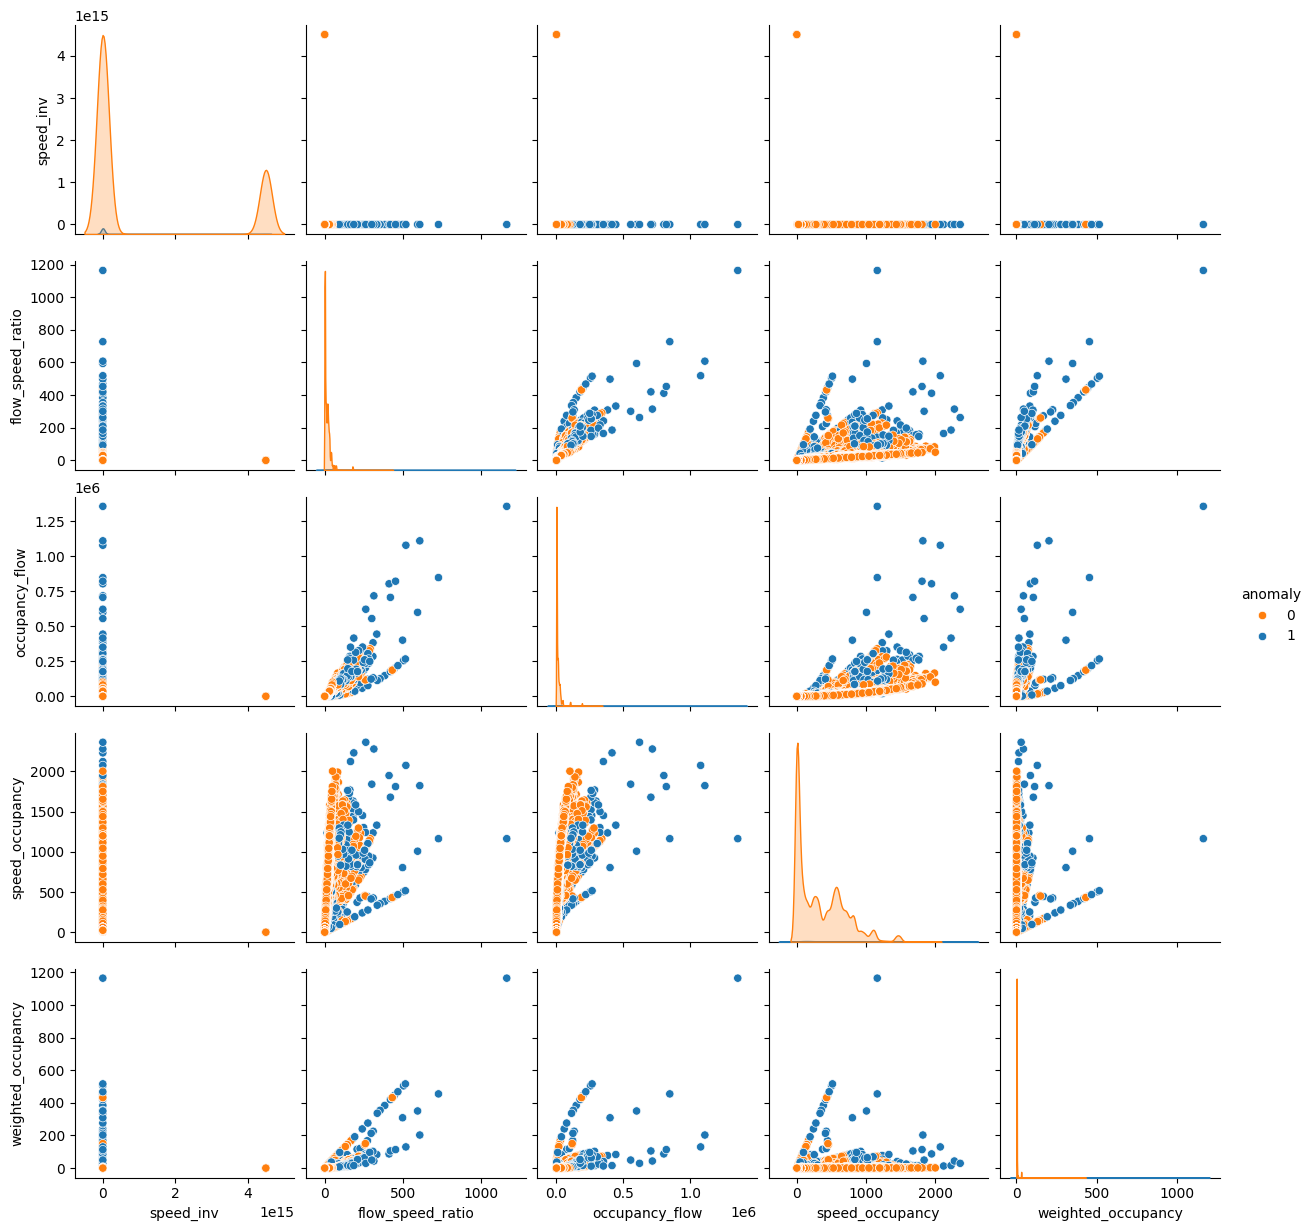

In [3]:
# Optimize DBSCAN
#from sklearn.cluster import DBSCAN
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import silhouette_score
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#
## Assuming 'df' is your DataFrame with traffic data
#
## Prepare a range of values for eps and min_samples
#eps_values = np.arange(0.1, 1.0, 0.1)
#min_samples_values = range(2, 10)
#best_eps = None
#best_min_samples = None
#best_silhouette = -1
#best_model = DBSCAN()  # Default model
#
#det_ids = df['detid'].unique()
#combined_results = pd.DataFrame()
#
#scaler = StandardScaler()
#
#for det_id in det_ids:
#    sensor_data = df[df['detid'] == det_id].copy()
#    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps
#
#    # Feature Engineering
#    sensor_data['speed_inv'] = 1 / sensor_data['speed']
#    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
#    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
#    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
#    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']
#    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
#    X_scaled = scaler.fit_transform(sensor_data[features_to_scale])
#
#    for eps in eps_values:
#        for min_samples in min_samples_values:
#            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#            cluster_labels = dbscan.fit_predict(X_scaled)
#            if len(set(cluster_labels)) > 1:
#                silhouette_avg = silhouette_score(X_scaled, cluster_labels)
#                if silhouette_avg > best_silhouette:
#                    best_silhouette = silhouette_avg
#                    best_eps = eps
#                    best_min_samples = min_samples
#                    best_model = dbscan
#
#    # Apply best model
#    sensor_data['clusters'] = best_model.fit_predict(X_scaled)
#    sensor_data['anomaly'] = (sensor_data['clusters'] == -1).astype(int)
#    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)
#
## Output the best parameters
#print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Best silhouette score: {best_silhouette}")
#
## Plot results
#palette = ['#ff7f0e', '#1f77b4']
#sns.pairplot(combined_results, vars=features_to_scale, hue='anomaly', palette=palette)
#plt.show()

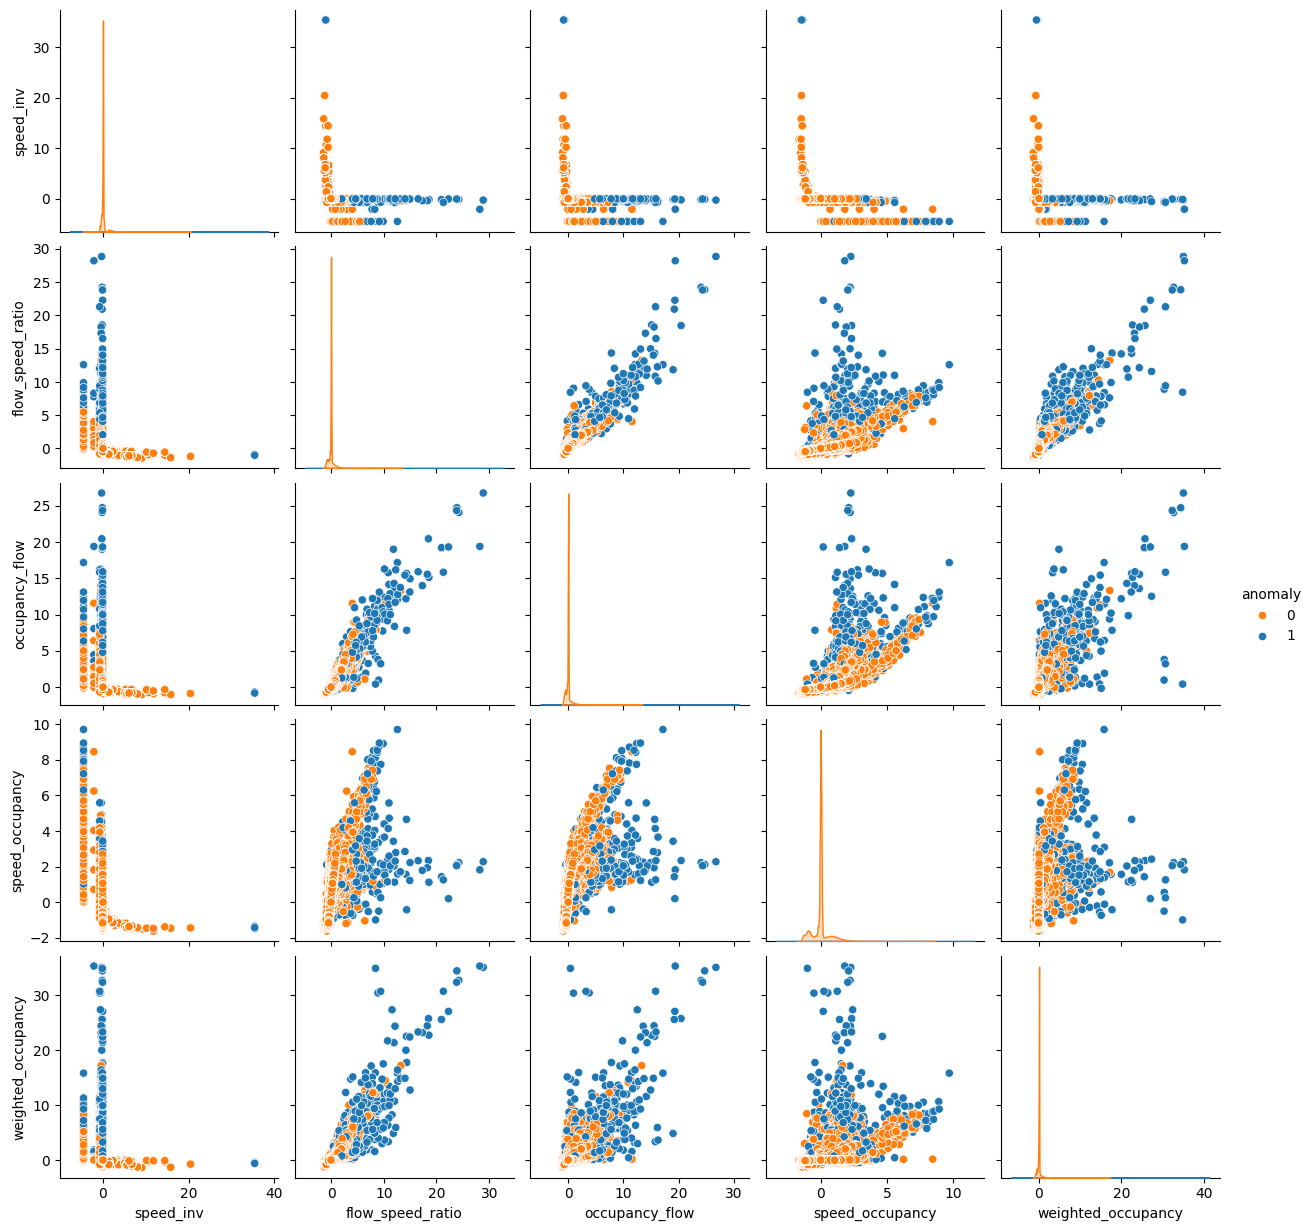

In [13]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Dataset identifiers
det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

scaler = StandardScaler()

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Handle zero speeds
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps

    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']
    
    # Scale features
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # DBSCAN
    dbscan = DBSCAN(eps=0.9, min_samples=2)  # Adjust these parameters based on your data characteristics
    sensor_data['clusters'] = dbscan.fit_predict(sensor_data[features_to_scale])
    
    # Detect anomalies
    sensor_data['anomaly'] = (sensor_data['clusters'] == -1).astype(int)
    
    # Store model and results
    sensor_models[det_id] = dbscan
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']  # Orange for normal, blue for anomalies
sns.pairplot(combined_results, vars=['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy'], hue='anomaly', palette=palette)
plt.show()

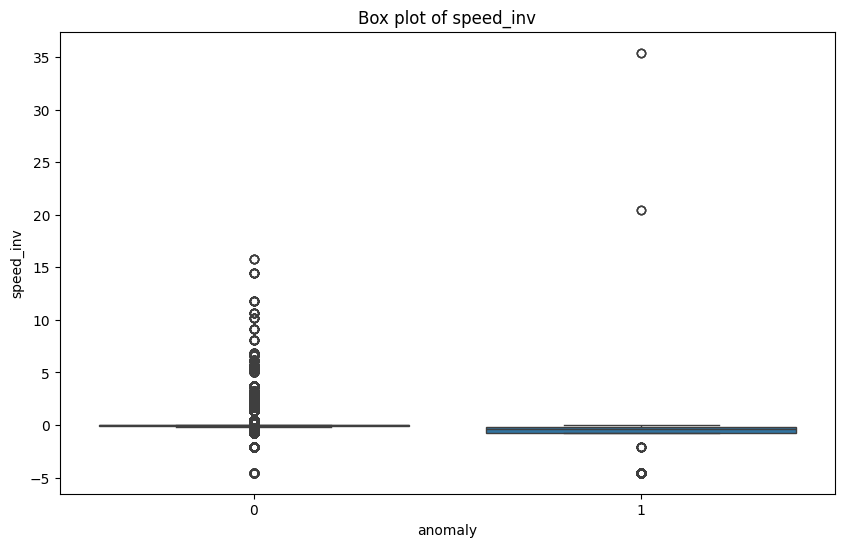

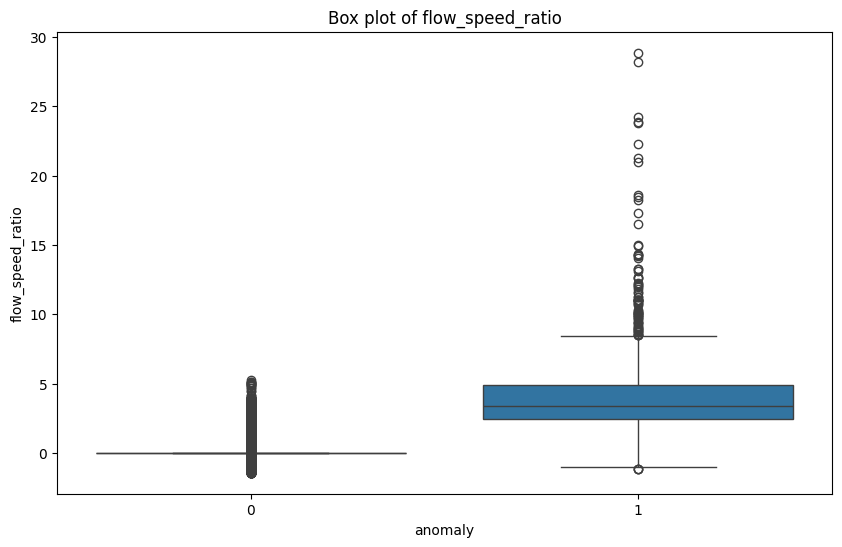

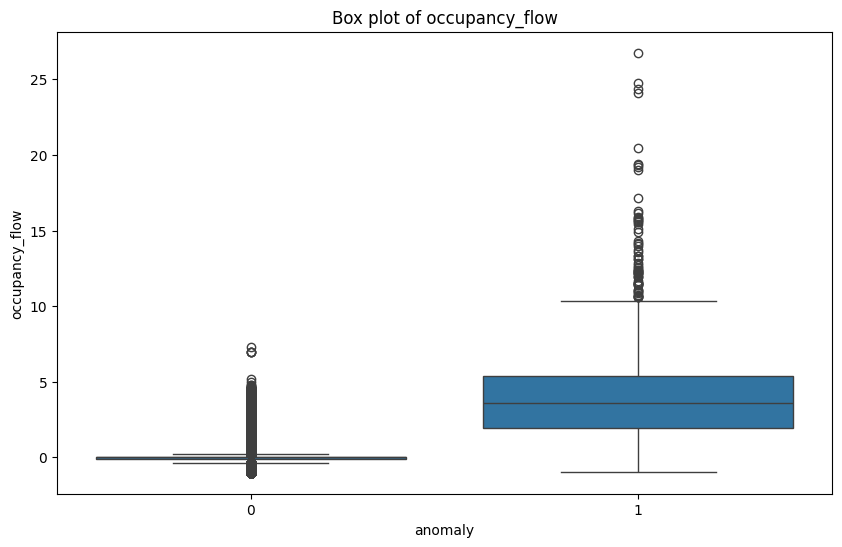

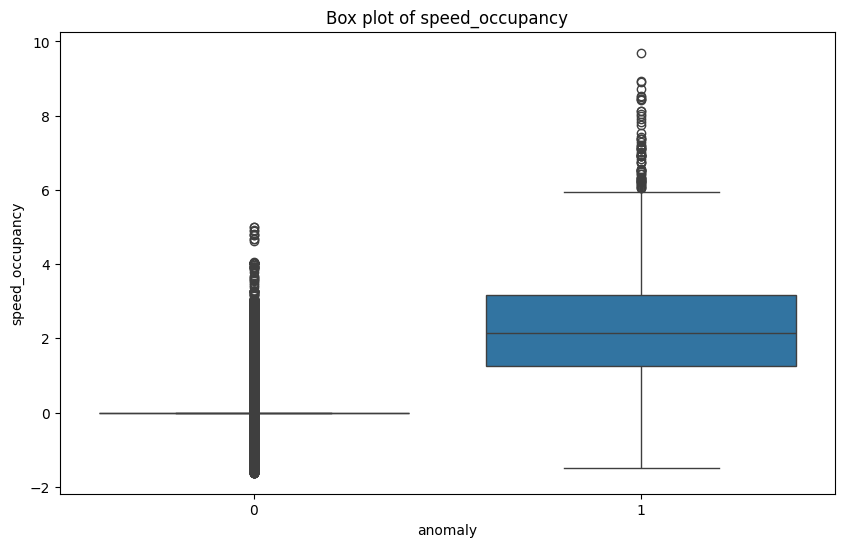

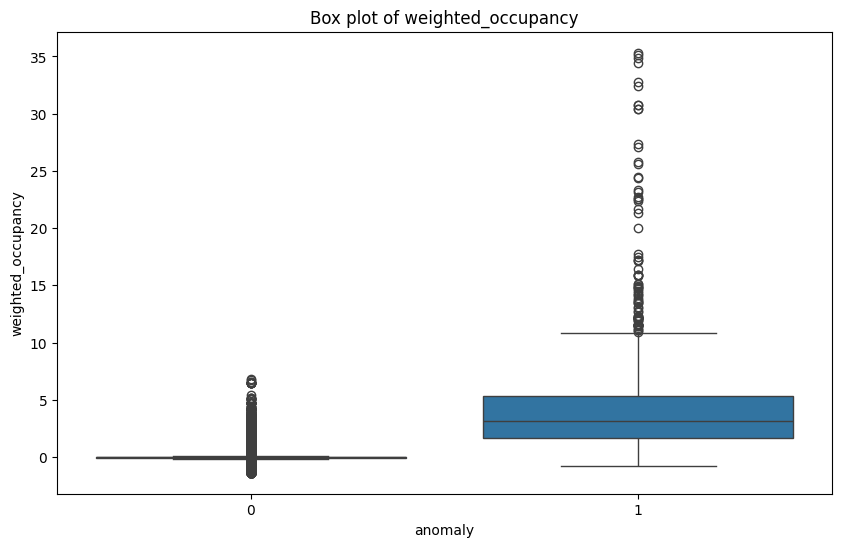

In [3]:
# Display Box Plot

features_to_plot = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='anomaly', y=feature, data=combined_results)
    plt.title(f'Box plot of {feature}')
    plt.show()

In [4]:
# DBSCAN without Feature Engineering

det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Scale features
    features_to_scale = ['speed', 'flow', 'occ']
    scaler = StandardScaler()
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # Train model
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    svm.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = svm

    # Anomaly score and label
    sensor_data['anomaly_score'] = svm.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = svm.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(combined_results, vars=['speed', 'flow', 'occ'], hue='anomaly', palette=palette)

plt.show()

NameError: name 'OneClassSVM' is not defined